In [1]:
!pip install rouge
!pip install pyarrow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, AdditiveAttention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rouge import Rouge


In [3]:
from google.colab import drive
from sklearn.model_selection import train_test_split
import os

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/ds1.parquet'

if os.path.exists(file_path):
    print("File Founded.")

    df = pd.read_parquet(file_path)
    df['prediction'] = df['prediction'].apply(lambda x: x[0]['text'])
    df['prediction'] = df['prediction'].apply(lambda x: f"<sos> {x} <eos>")
    train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)


    print(f"Train set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    print(f"Test set size: {len(test_data)}")
else:
    print("Dosya bulunamadı. Lütfen yolunuzu kontrol edin.")


Mounted at /content/drive
File Founded.
Train set size: 16333
Validation set size: 2042
Test set size: 2042


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re


def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^a-zA-Z0-9.,!?\'\s]', '', text)
        return text.strip()
    return '<unk>'

def prepare_tokenizer(train_texts, num_words=30000):
    tokenizer = Tokenizer(num_words=num_words, oov_token='<unk>')
    tokenizer.fit_on_texts(train_texts)
    tokenizer.word_index['<sos>'] = len(tokenizer.word_index) + 1
    tokenizer.word_index['<eos>'] = len(tokenizer.word_index) + 1
    tokenizer.index_word = {v: k for k, v in tokenizer.word_index.items()}
    return tokenizer

def preprocess_texts(texts, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded


def analyze_text_lengths(texts):
    lengths = [len(text.split()) for text in texts if isinstance(text, str)]
    max_length = max(lengths)
    avg_length = sum(lengths) // len(lengths)
    print(f"Max length: {max_length}, Average length: {avg_length}")
    return max_length

train_data['text'] = train_data['text'].astype(str).apply(clean_text)
train_data['prediction'] = train_data['prediction'].astype(str).apply(clean_text)
val_data['text'] = val_data['text'].astype(str).apply(clean_text)
val_data['prediction'] = val_data['prediction'].astype(str).apply(clean_text)

train_texts = train_data['text'].tolist()
train_summaries = [f"<sos> {text} <eos>" for text in train_data['prediction'].tolist()]
tokenizer = prepare_tokenizer(train_texts + train_summaries, num_words=30000)

max_len_text = min(100, analyze_text_lengths(train_texts))
max_len_summary = min(30, analyze_text_lengths(train_summaries))

X_train = preprocess_texts(train_texts, tokenizer, max_len=max_len_text)
Y_train = preprocess_texts(train_summaries, tokenizer, max_len=max_len_summary)
X_val = preprocess_texts(val_data['text'].tolist(), tokenizer, max_len=max_len_text)
Y_val = preprocess_texts([f"<sos> {text} <eos>" for text in val_data['prediction'].tolist()], tokenizer, max_len=max_len_summary)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_val shape: {Y_val.shape}")

Max length: 5138, Average length: 382
Max length: 24, Average length: 13
X_train shape: (16333, 100)
Y_train shape: (16333, 24)
X_val shape: (2042, 100)
Y_val shape: (2042, 24)


In [6]:
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')

In [7]:
import os
import numpy as np

glove_path = '/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt'

if os.path.exists(glove_path):
    print("GloVe File Found. Loading...")

    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"A total of {len(embeddings_index)} word embeddings have been loaded.")
else:
    print("GloVe file not found. Please check your path.")


embedding_matrix = np.zeros((30000, 100))
for word, i in tokenizer.word_index.items():
    if i < 30000:
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

GloVe File Found. Loading...
A total of 400000 word embeddings have been loaded.
Embedding matrix shape: (30000, 100)


In [8]:
from tensorflow.keras.layers import Input, Embedding, LSTM

encoder_input = Input(shape=(None,), name="encoder_input")
encoder_embedding = Embedding(
    input_dim=30000,
    output_dim=100,
    weights=[embedding_matrix],
    trainable=True,
    name="encoder_embedding"
)(encoder_input)

encoder_lstm, state_h, state_c = LSTM(
    512,
    return_sequences=True,
    return_state=True,
    dropout=0.5,
    name="encoder_lstm"
)(encoder_embedding)

from tensorflow.keras.layers import Input, Embedding, LSTM


decoder_input = Input(shape=(None,), name="decoder_input")
decoder_embedding = Embedding(
    input_dim=30000,
    output_dim=100,
    weights=[embedding_matrix],
    trainable=True,
    name="decoder_embedding"
)(decoder_input)

decoder_lstm, _, _ = LSTM(
    512,
    return_sequences=True,
    return_state=True,
    dropout=0.5,
    name="decoder_lstm"
)(decoder_embedding, initial_state=[state_h, state_c])

from tensorflow.keras.layers import AdditiveAttention

attention = AdditiveAttention(name="attention_layer")
attention_output = attention([decoder_lstm, encoder_lstm])

from tensorflow.keras.layers import Dense

decoder_dense = Dense(
    30000,
    activation='softmax',
    name="output_layer"
)(attention_output)

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model([encoder_input, decoder_input], decoder_dense)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, None, 100)      │      3,000,000 │ encoder_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 100)      │      3,000,000 │ decoder_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm (LSTM)       │ [(None, None, 512),    │      1,255,424 │ encoder_embedding[0][… │
│                           │ (None, 512), (None,    │                │                        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, None, 512),    │      1,255,424 │ decoder_embedding[0][… │
│                           │ (None, 512), (None,    │                │ encoder_lstm[0][1],    │
│                           │ 512)]                  │                │ encoder_lstm[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 512)      │            512 │ decoder_lstm[0][0],    │
│ (AdditiveAttention)       │                        │                │ encoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, None, 30000)    │     15,390,000 │ attention_layer[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,901,360 (91.18 MB)

 Trainable params: 23,901,360 (91.18 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    [X_train, Y_train[:, :-1]],
    Y_train[:, 1:],
    validation_data=([X_val, Y_val[:, :-1]], Y_val[:, 1:]),
    batch_size=32,
    epochs=15,
    callbacks=[early_stopping]
)

Epoch 1/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.4541 - loss: 4.6408 - val_accuracy: 0.5801 - val_loss: 3.1995
Epoch 2/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.5829 - loss: 3.1135 - val_accuracy: 0.5917 - val_loss: 3.0062
Epoch 3/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.5950 - loss: 2.8763 - val_accuracy: 0.6027 - val_loss: 2.8338
Epoch 4/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.6053 - loss: 2.6787 - val_accuracy: 0.6096 - val_loss: 2.7164
Epoch 5/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.6148 - loss: 2.4825 - val_accuracy: 0.6155 - val_loss: 2.6315
Epoch 6/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.6221 - loss: 2.3449 - val_accuracy: 0.6214 - val_loss: 2.5726
Epoch 7/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.6275 - loss: 2.2244 - val_accuracy: 0.6242 - val_loss: 2.5296
Epoch 8/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.6321 - loss: 2.1265 - 

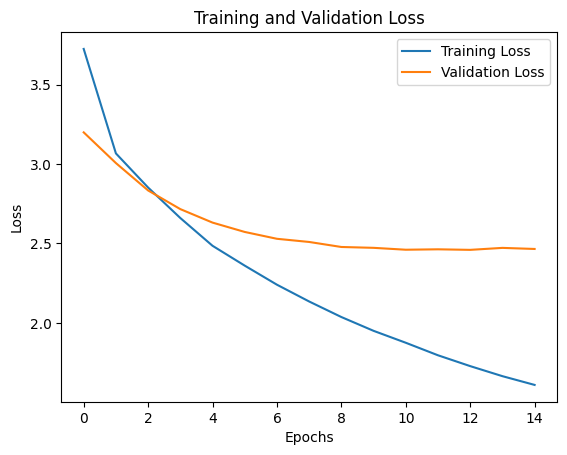

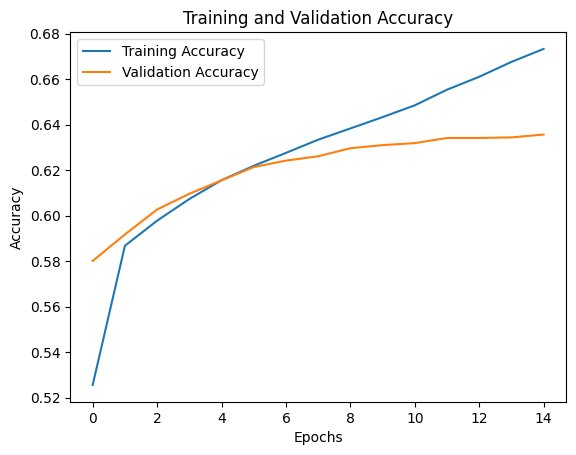

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [11]:
from rouge import Rouge
import numpy as np
import tensorflow as tf

def generate_summaries_batch(X_val, model, tokenizer, max_len=30):

    batch_size = X_val.shape[0]

    target_seq = np.zeros((batch_size, max_len))
    target_seq[:, 0] = tokenizer.word_index['<sos>']

    summaries = [[] for _ in range(batch_size)]

    finished = [False] * batch_size

    for i in range(1, max_len):
        predictions = model.predict([X_val, target_seq], verbose=0)
        sampled_tokens = np.argmax(predictions[:, i - 1, :], axis=1)

        for j, token in enumerate(sampled_tokens):
            if not finished[j]:
                word = tokenizer.index_word.get(token, '<unk>')
                if word == '<eos>':
                    finished[j] = True
                else:
                    summaries[j].append(word)
                    target_seq[j, i] = token

        if all(finished):
            break

    generated_summaries = [' '.join(summary) for summary in summaries]
    return generated_summaries

generated_summaries = generate_summaries_batch(X_val, model, tokenizer)

reference_summaries = val_data['prediction'].astype(str).tolist()

rouge = Rouge()
scores = rouge.get_scores(generated_summaries, reference_summaries, avg=True)

print("ROUGE Scores:")
print(scores)


ROUGE Scores:
{'rouge-1': {'r': 0.35340052578080994, 'p': 0.44734868053918, 'f': 0.38929650096714963}, 'rouge-2': {'r': 0.08833880522248366, 'p': 0.07702173013010007, 'f': 0.08156925933524184}, 'rouge-l': {'r': 0.342887365106047, 'p': 0.4344776985447895, 'f': 0.37783724067219393}}
